In [1]:
import xrft
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from matplotlib import colors, ticker, cm
from xhistogram.xarray import histogram 
import pandas as pd
from matplotlib import colors as cols

In [2]:
import matplotlib 
font = {'family' : 'sans-serif',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
npick = 24*1 # pick up npick file
dt_out = 90
T1 =  196560 # 3months + 1 day
T2months = 291060 # 4.5 months

iters = range(T1, T2months, dt_out*npick)
#iters = T2months

data_dir = '/swot/SUM04/dbalwada/channel_beta/01km/tracer_exp2/' 

ds = open_mdsdataset(data_dir, delta_t=40, iters= iters, 
                            prefix=['U','V','W','PTRACER01','tracer1_diag']
                     ,ignore_unknown_vars=True, geometry='cartesian')

In [4]:
horispace = 1e3
time_index = 0
depth = -50
f =  -0.83e-4
X = ds.XC/1e3
Y = ds.YC/1e3
daytime = 86400
boxarea = horispace**2
ybound = 5e5

In [5]:
grid = Grid(ds, periodic='X')

In [6]:
hab01L = xr.open_dataarray('/home/qx344/data/hab01-longtime')
hab05L = xr.open_dataarray('/home/qx344/data/hab05-longtime')
vortold = np.linspace(-7, 7, 240)
strainold = np.linspace(.5e-3, 7, 240)
binbox01old =  (vortold[1]-vortold[0])*(strainold[1]-strainold[0])

In [7]:
vort_1d = grid.interp(grid.interp((grid.diff(ds.V, 'X') - grid.diff(ds.U, 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace

strain_1d = ((grid.diff(ds.U, 'X') - grid.diff(ds.V, 'Y', boundary='extend'))**2 + 
          (grid.interp(grid.interp(grid.diff(ds.V, 'X') + grid.diff(ds.U, 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace

In [8]:
vort_1d = vort_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)
strain_1d = strain_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)
vort_1d = (vort_1d/f).rename('vort1_0')
strain_1d = (abs(strain_1d/f)).rename('strain1_0')

In [9]:
vort_1d.load();
strain_1d.load();

In [10]:
vortband01 = np.linspace(-7, 7, 240)
strainband01 = np.linspace(.5e-3, 7, 240)

binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])


In [11]:

hist01TMean = hab01L
mask_vortDom = xr.where(abs(hist01TMean.vort1_0_bin)>abs(hist01TMean.strain1_0_bin),1,0)
mask_ac = xr.where(hist01TMean.vort1_0_bin<0,1,0)
mask_c = xr.where(hist01TMean.vort1_0_bin>0,1,0)
mask_strDom = xr.where(abs(hist01TMean.vort1_0_bin)<abs(hist01TMean.strain1_0_bin),1,0)

hist05TMean = (5**2)/(binbox01*2000*1000)*hab05L
mask_in5km = xr.where(hist05TMean<1e-5, 0, 1)
mask_out5km = xr.where(hist05TMean<1e-5, 1, 0)

In [15]:
DifZup = np.zeros([76])
DifZmid = np.zeros([76])
DifZac = np.zeros([76])
DifZc = np.zeros([76])
for depthInd in range(76):
    diffusionDepth = grid.interp(ds.DFrITr01, 'Z', boundary='extend').isel(Z=depthInd).sel(YC = slice(ybound,2e6-ybound)).rename('diff01')
    diffusionDepth.load()

    hab01_Diff = histogram(vort_1d, strain_1d, weights = diffusionDepth, dim = ['XC','YC'] , bins=[vortband01,strainband01])
    hab01_Difftm = hab01_Diff.mean(dim='time')
    hab01_Difftm.load()
    DifZup[depthInd] = (hab01_Difftm*mask_out5km*mask_strDom).sum().values[()]/(1000**2)
    DifZac[depthInd] = (hab01_Difftm*mask_vortDom*mask_ac).sum().values[()]/(1000**2)
    DifZc[depthInd] = (hab01_Difftm*mask_vortDom*mask_c).sum().values[()]/(1000**2)
    DifZmid[depthInd] = (hab01_Difftm*mask_in5km*mask_strDom).sum().values[()]/(1000**2)
    print(depthInd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [16]:
1+1

2

(-20.0, 20.0)

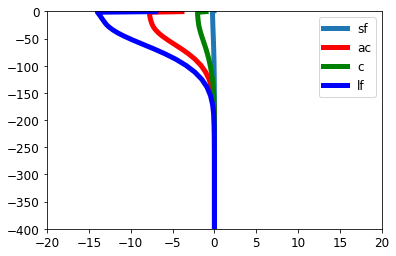

In [17]:
plt.plot(DifZup, ds.Z.values, linewidth = 5)
plt.plot(DifZac, ds.Z.values, linewidth = 5,color = 'r')
plt.plot(DifZc, ds.Z.values, linewidth = 5,color ='g')
plt.plot(DifZmid, ds.Z.values, linewidth = 5,color ='b')

plt.legend(['sf','ac','c','lf'])
plt.ylim(-400,0)
plt.xlim(-20,20)

In [12]:
surfTracer = ds.PTRACER01
sorfForce = (1-surfTracer).isel(Z=0).sel(YC = slice(ybound,2e6-ybound))/(72*60)

hab01_1SF = histogram(vort_1d,strain_1d, weights = sorfForce, dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab01_1SF.load();

In [13]:
SFup = (hab01_1SF.mean(dim='time')*mask_out5km*mask_strDom).sum().values[()]
SFac = (hab01_1SF.mean(dim='time')*mask_vortDom*mask_ac).sum().values[()]
SFc= (hab01_1SF.mean(dim='time')*mask_vortDom*mask_c).sum().values[()]
SFmid = (hab01_1SF.mean(dim='time')*mask_in5km*mask_strDom).sum().values[()]

In [14]:
print(SFup,SFac,SFc,SFmid)

0.2693270942134104 7.6998566079772015 1.8564787017918651 14.265757651489874
